In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, EvokedArray
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [6]:
epochs = read_epochs('ica_epo.fif').pick('eeg')
epochs.drop_channels(epochs.info['bads'])

Reading c:\Users\at18157\Desktop\bci\data\ah\ica_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


Number of events,74
Events,left: 14r_pinch: 15r_stop: 16rest: 13right: 16
Time range,-2.000 – 7.999 sec
Baseline,off


In [16]:
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.5,-0.1))
imagery_epochs = subset['left','right'].copy().crop(-0.2,2)
rest_epochs = subset['rest'].copy().crop(-0.2,2)

Applying baseline correction (mode: mean)


PCA

In [85]:
pca = PCA(len(subset.info['chs']))

5-20Hz

In [153]:
X_im = imagery_epochs.copy().crop(-0.1,1.5).filter(5,20, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_im.shape
X_im = np.transpose(X_im,(1,0,2)).reshape(n_chan, n_eps*n_time).T

C:\Users\at18157\AppData\Local\Temp\ipykernel_5252\728237523.py:1: RuntimeWarning: filter_length (1691) is longer than the signal (1639), distortion is likely. Reduce filter length or filter a longer signal.
  X_im = imagery_epochs.copy().crop(-0.1,1.5).filter(5,20, n_jobs=4, verbose=False).get_data()


In [154]:
X_im = pca.fit_transform(X_im)


In [155]:
X_im = X_im.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))

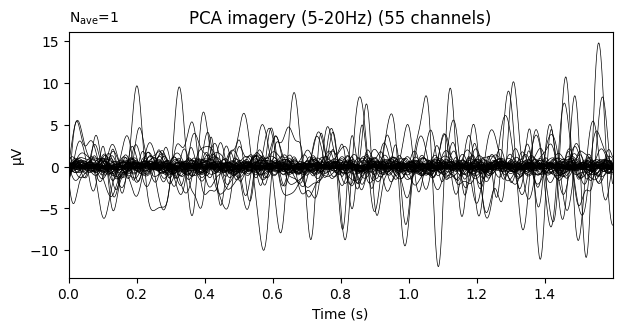

In [156]:
ev = EvokedArray(np.mean(X_im, axis=0), imagery_epochs.info)
ev.plot(spatial_colors=False, titles='PCA imagery (5-20Hz)', show=False)
print()

In [157]:
X_rst = rest_epochs.copy().crop(-0.1,1.5).filter(5,20, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_rst.shape
X_rst = np.transpose(X_rst,(1,0,2)).reshape(n_chan, n_eps*n_time).T

C:\Users\at18157\AppData\Local\Temp\ipykernel_5252\2239228806.py:1: RuntimeWarning: filter_length (1691) is longer than the signal (1639), distortion is likely. Reduce filter length or filter a longer signal.
  X_rst = rest_epochs.copy().crop(-0.1,1.5).filter(5,20, n_jobs=4, verbose=False).get_data()


In [158]:
X_rst = pca.fit_transform(X_rst)
X_rst = X_rst.T.reshape((-1, n_eps, n_time)).transpose((1,0,2)) 

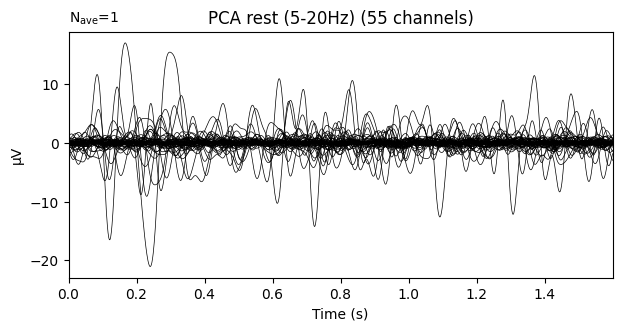

In [159]:
ev = EvokedArray(np.mean(X_rst, axis=0), rest_epochs.info)
ev.plot(spatial_colors=False, titles='PCA rest (5-20Hz)')
print()

20-35Hz

In [161]:
X_im = imagery_epochs.copy().crop(-0.1,1.5).filter(20,35, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_im.shape
X_im = np.transpose(X_im,(1,0,2)).reshape(n_chan, n_eps*n_time).T

In [162]:
X_im = pca.fit_transform(X_im)
X_im = X_im.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))

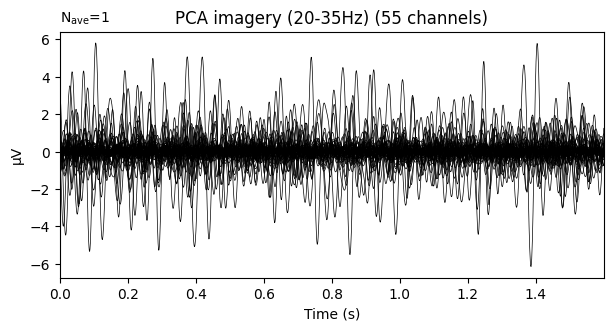

In [163]:
ev = EvokedArray(np.mean(X_im, axis=0), imagery_epochs.info)
ev.plot(spatial_colors=False, titles='PCA imagery (20-35Hz)', show=False)
print()

In [164]:
X_rst = rest_epochs.copy().crop(-0.1,1.5).filter(20,35, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_rst.shape
X_rst = np.transpose(X_rst,(1,0,2)).reshape(n_chan, n_eps*n_time).T

In [165]:
X_rst = pca.fit_transform(X_rst)
X_rst = X_rst.T.reshape((-1, n_eps, n_time)).transpose((1,0,2)) 

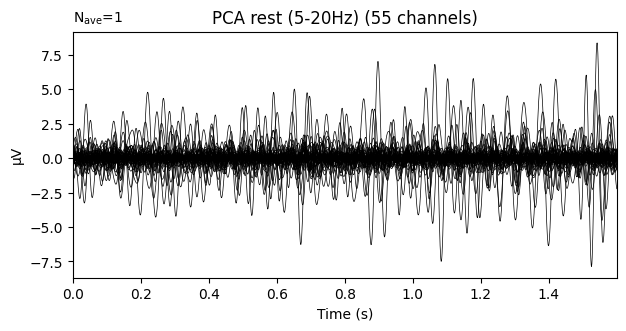

In [166]:
ev = EvokedArray(np.mean(X_rst, axis=0), rest_epochs.info)
ev.plot(spatial_colors=False, titles='PCA rest (5-20Hz)')
print()

70-90Hz

In [ ]:
X_im = imagery_epochs.copy().crop(-0.1,1.5).filter(70,90, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_im.shape
X_im = np.transpose(X_im,(1,0,2)).reshape(n_chan, n_eps*n_time).T

In [ ]:
X_im = pca.fit_transform(X_im)
X_im = X_im.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))

In [ ]:
ev = EvokedArray(np.mean(X_im, axis=0), imagery_epochs.info)
ev.plot(spatial_colors=False, titles='PCA imagery (20-35Hz)', show=False)
print()